In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/CMPT733-Lab2-Workspace")

In [ ]:
![ ! -d "data" ] && wget -nc https://www.repository.cam.ac.uk/bitstream/handle/1810/251342/KingsCollege.zip
![ ! -d "data" ] && mkdir data && unzip -qq KingsCollege.zip -d "data/" && rm KingsCollege.zip
![ ! -d "checkpoints" ] && mkdir "checkpoints/"
!echo "done!"

done!


In [ ]:
!ls

checkpoints   checkpointsC120	 checkpoints_MSE  data	pretrained_models
checkpointsC  checkpointsC_b150  checkpoints_S	  Long


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle


def init(key, module, weights=None):
    if weights == None:
        return module

    # initialize bias.data: layer_name_1 in weights
    # initialize  weight.data: layer_name_0 in weights
    module.bias.data = torch.from_numpy(weights[(key + "_1").encode()])
    module.weight.data = torch.from_numpy(weights[(key + "_0").encode()])

    return module


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes, key=None, weights=None):
        super(InceptionBlock, self).__init__()

        # TODO: Implement InceptionBlock
        # Use 'key' to load the pretrained weights for the correct InceptionBlock

        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels,n1x1,1),
            nn.ReLU()
        )

        # 1x1 -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels,n3x3red,1),
            nn.ReLU(),
            nn.Conv2d(n3x3red,n3x3,3,padding=1),
            nn.ReLU()
        )

        # 1x1 -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_channels,n5x5red,1),
            nn.ReLU(),
            nn.Conv2d(n5x5red,n5x5,5,padding=2),
            nn.ReLU()
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels,pool_planes,1),
            nn.ReLU()
        )

    def forward(self, x):
        # TODO: Feed data through branches and concatenate
        x1 = self.b1(x)
        x2 = self.b2(x)
        x3 = self.b3(x)
        x4 = self.b4(x)
        x = torch.cat([x1,x2,x3,x4],dim = 1)
        return x


In [ ]:
class LossHeader(nn.Module):
    def __init__(self, key, weights=None):
        super(LossHeader, self).__init__()

        # TODO: Define loss headers
        self.key = key
        if key == 'A':
            self.pool = nn.Sequential(
                nn.AvgPool2d(kernel_size=5,stride=3),
                nn.ReLU(),
                nn.Conv2d(512,128,kernel_size=1),
                nn.ReLU(),
                nn.Flatten()
            )
            self.fc = nn.Linear(2048,1024)
            self.relu = nn.ReLU()
            self.drop_out = nn.Dropout(p = 0.7)
            self.fc_3 = nn.Linear(1024,3)
            self.fc_4 = nn.Linear(1024,4)
        elif key == 'B':
            self.pool = nn.Sequential(
                nn.AvgPool2d(kernel_size=5,stride=3),
                nn.ReLU(),
                nn.Conv2d(528,128,kernel_size=1),
                nn.ReLU(),
                nn.Flatten()
            )
            self.fc = nn.Linear(2048,1024)
            self.relu = nn.ReLU()
            self.drop_out = nn.Dropout(p = 0.7)
            self.fc_3 = nn.Linear(1024,3)
            self.fc_4 = nn.Linear(1024,4)
        elif key == 'C':
            self.pool = nn.Sequential(
                nn.AvgPool2d(kernel_size=7,stride=1),
                nn.ReLU(),
                nn.Flatten()
            )
            self.fc = nn.Linear(1024,2048)
            self.relu = nn.ReLU()
            self.drop_out = nn.Dropout(p = 0.4)
            self.fc_3 = nn.Linear(2048,3)
            self.fc_4 = nn.Linear(2048,4)

    def forward(self, x):
        # TODO: Feed data through loss headers
        x = self.pool(x)
        x = self.fc(x)
        x = self.relu(x)
        x = self.drop_out(x)
        xyz = self.fc_3(x)
        wpqr = self.fc_4(x)
            
        return xyz, wpqr


class PoseNet(nn.Module):
    def __init__(self, load_weights=True):
        super(PoseNet, self).__init__()

        # Load pretrained weights file
        if load_weights:
            print("Loading pretrained InceptionV1 weights...")
            file = open('pretrained_models/places-googlenet.pickle', "rb")
            weights = pickle.load(file, encoding="bytes")
            print(weights.keys())
            file.close()
        # Ignore pretrained weights
        else:
            weights = None

        # TODO: Define PoseNet layers

        self.pre_layers = nn.Sequential(
            # Example for defining a layer and initializing it with pretrained weights
            init('conv1/7x7_s2', nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), weights),
            nn.ReLU(),
            init('maxpool1/3x3_s2',nn.MaxPool2d(kernel_size=3,stride=2,padding=1)),
            nn.ReLU(),
            nn.CrossMapLRN2d(5, 0.0001, 0.75, 1),
            init('conv2/3x3_reduce',nn.Conv2d(64,64,kernel_size=1),weights),
            nn.ReLU(),
            init('conv2/3x3',nn.Conv2d(64,192,kernel_size=3,padding=1),weights),
            nn.ReLU(),
            nn.CrossMapLRN2d(5, 0.0001, 0.75, 1),
            init('maxpool2/3x3_s2',nn.MaxPool2d(kernel_size=3,stride=2,padding=1)),
            nn.ReLU()
        )

        # Example for InceptionBlock initialization
        self._3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32, "3a", weights)
        self._3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64, "3b", weights)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self._4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64, "4a", weights)
        self._4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64, "4b", weights)
        self._4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64, "4c", weights)
        self._4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64, "4d", weights)
        self._4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128, "4e", weights)
        self._5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128, "5a", weights)
        self._5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128, "5b", weights)
        self.loss1 = LossHeader('A',weights)
        self.loss2 = LossHeader('B',weights)
        self.loss3 = LossHeader('C',weights)

        print("PoseNet model created!")

    def forward(self, x):
        # TODO: Implement PoseNet forward
        x = self.pre_layers(x)
        x = self._3a(x)
        x = self.maxpool(self._3b(x))
        x = self._4a(x)
        loss1_xyz, loss1_wpqr = self.loss1(x)
        x = self._4b(x)
        x = self._4c(x)
        x = self._4d(x)
        loss2_xyz, loss2_wpqr = self.loss2(x)
        x = self.maxpool(self._4e(x))
        x = self._5a(x)
        x = self._5b(x)
        loss3_xyz, loss3_wpqr = self.loss3(x)

        if self.training:
            return loss1_xyz, \
                   loss1_wpqr, \
                   loss2_xyz, \
                   loss2_wpqr, \
                   loss3_xyz, \
                   loss3_wpqr
        else:
            return loss3_xyz, \
                   loss3_wpqr




In [ ]:
class PoseLoss(nn.Module):

    def __init__(self, w1_xyz, w2_xyz, w3_xyz, w1_wpqr, w2_wpqr, w3_wpqr):
        super(PoseLoss, self).__init__()

        self.w1_xyz = w1_xyz
        self.w2_xyz = w2_xyz
        self.w3_xyz = w3_xyz
        self.w1_wpqr = w1_wpqr
        self.w2_wpqr = w2_wpqr
        self.w3_wpqr = w3_wpqr


    def forward(self, p1_xyz, p1_wpqr, p2_xyz, p2_wpqr, p3_xyz, p3_wpqr, poseGT):
        # TODO: Implement loss
        # First 3 entries of poseGT are ground truth xyz, last 4 values are ground truth wpqr
        loss = nn.MSELoss(reduction='none')
        gt_xyz = poseGT[:,0:3]
        gt_wpqr = F.normalize(poseGT[:,3:7])
        loss1_xyz = torch.sum(torch.sqrt(torch.sum(loss(p1_xyz, gt_xyz),dim = 1)))
        loss1_wpqr = torch.sum(torch.sqrt(torch.sum(loss(p1_wpqr, gt_wpqr),dim = 1)))
        loss2_xyz = torch.sum(torch.sqrt(torch.sum(loss(p2_xyz, gt_xyz),dim = 1)))
        loss2_wpqr = torch.sum(torch.sqrt(torch.sum(loss(p2_wpqr, gt_wpqr),dim = 1)))
        loss3_xyz = torch.sum(torch.sqrt(torch.sum(loss(p3_xyz, gt_xyz),dim = 1)))
        loss3_wpqr = torch.sum(torch.sqrt(torch.sum(loss(p3_wpqr, gt_wpqr),dim = 1)))
        loss = self.w1_xyz * (loss1_xyz + self.w1_wpqr * loss1_wpqr) + self.w2_xyz * (loss2_xyz + self.w2_wpqr * loss2_wpqr) + self.w3_xyz * (loss3_xyz + self.w3_wpqr * loss3_wpqr)

        return loss


In [ ]:
import os
import torch.utils.data as data
from torchvision import transforms as T
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

class DataSource(data.Dataset):
    def __init__(self, root, resize=256, crop_size=224, train=True):
        self.root = os.path.expanduser(root)
        self.resize = resize
        self.crop_size = crop_size
        self.train = train

        self.image_poses = []
        self.images_path = []

        self._get_data()

        # TODO: Define preprocessing
        #,transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        self.trans_train = transforms.Compose([transforms.RandomCrop(224)])
        self.trans_test = transforms.Compose([transforms.CenterCrop(224)])
        # Load mean image
        self.mean_image_path = os.path.join(self.root, 'mean_image.npy')
        if os.path.exists(self.mean_image_path):
            self.mean_image = np.load(self.mean_image_path)
            print("Mean image loaded!")
        else:
            self.mean_image = self.generate_mean_image()

    def _get_data(self):

        if self.train:
            txt_file = self.root + 'dataset_train.txt'
        else:
            txt_file = self.root + 'dataset_test.txt'

        with open(txt_file, 'r') as f:
            next(f)  # skip the 3 header lines
            next(f)
            next(f)
            for line in f:
                fname, p0, p1, p2, p3, p4, p5, p6 = line.split()
                p0 = float(p0)
                p1 = float(p1)
                p2 = float(p2)
                p3 = float(p3)
                p4 = float(p4)
                p5 = float(p5)
                p6 = float(p6)
                self.image_poses.append((p0, p1, p2, p3, p4, p5, p6))
                self.images_path.append(self.root + fname)

    def generate_mean_image(self):
        print("Computing mean image:")

        # TODO: Compute mean image
        n = 0
        mean_image = []
        for image_file in self.images_path:
            im = Image.open(image_file)
            sm_dim = np.min([im.size[0],im.size[1]])
            scale = sm_dim/self.resize
            tran = transforms.Resize([int(im.size[1]/scale),int(im.size[0]/scale)])
            if mean_image == []:
                mean_image = np.asarray(tran(im))
            else:
                mean_image = mean_image + np.asarray(tran(im))
            n = n + 1
        mean_image = mean_image / n
        np.save(os.path.join(self.root, 'mean_image.npy'),mean_image)
        # Initialize mean_image

        # Iterate over all training images
        # Resize, Compute mean, etc...

        # Store mean image

        print("Mean image computed!")

        return mean_image

    def __getitem__(self, index):
        """
        return the data of one image
        """
        img_path = self.images_path[index]
        img_pose = self.image_poses[index]

        data = Image.open(img_path)
        sm_dim = np.min([data.size[0],data.size[1]])
        scale = sm_dim/self.resize
        tran = transforms.Resize([int(data.size[1]/scale),int(data.size[0]/scale)])
        data = tran(data)
        data = torch.tensor((np.asarray(data) - self.mean_image).transpose(2,0,1))

        # TODO: Perform preprocessing
        if self.train == True:
            data = self.trans_train(data)
        else:
            data = self.trans_test(data)
        return data, img_pose

    def __len__(self):
        return len(self.images_path)

In [ ]:
import torch
import numpy as np
import torch.utils.data as Data
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.autograd import Variable
#from models.PoseNet import PoseNet, PoseLoss
#from data.DataSource import *
import os
import datetime
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

save_freq = 1

def train(epochs, batch_size, learning_rate, save_freq, data_dir):
    # train dataset and train loader
    datasource = DataSource(data_dir, train=True)
    train_loader = DataLoader(dataset=datasource, batch_size=batch_size, shuffle=True)

    # load model
    posenet = PoseNet().to(device,dtype=float)

    # loss function
    criterion = PoseLoss(0.3, 0.3, 1., 150, 150, 150)

    # train the network
    optimizer = torch.optim.Adam(nn.ParameterList(posenet.parameters()),
                     lr=learning_rate, eps=1,
                     weight_decay=0.0625,
                     betas=(0.9, 0.999))

    batches_per_epoch = len(train_loader.batch_sampler)
    starttime=datetime.datetime.now()
    loss_info = []
    for epoch in range(epochs):
        print("Starting epoch {}:".format(epoch))
        posenet.train()
        ttl_loss = 0
        ttl_item = 0
        for step, (images, poses) in enumerate(train_loader):
            b_images = Variable(images, requires_grad=True).to(device,dtype=float)
            poses[0] = np.array(poses[0]/50)
            poses[1] = np.array(poses[1]/50)
            poses[2] = np.array(poses[2]/50)
            poses[3] = np.array(poses[3])
            poses[4] = np.array(poses[4])
            poses[5] = np.array(poses[5])
            poses[6] = np.array(poses[6])
            poses = np.transpose(poses)
            b_poses = Variable(torch.Tensor(poses), requires_grad=True).to(device,dtype=float)
            p1_x, p1_q, p2_x, p2_q, p3_x, p3_q = posenet(b_images)
            loss = criterion(p1_x, p1_q, p2_x, p2_q, p3_x, p3_q, b_poses)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print("{}/{}: loss = {}".format(step+1, batches_per_epoch, loss))
            ttl_loss += loss
            ttl_item += p1_x.shape[0]
        ttl_loss = ttl_loss.detach().cpu().numpy()
        loss_info = np.append(loss_info, ttl_loss / ttl_item)
        #torch.save(posenet.state_dict(), save_path)
        
        
        # Save state
        if epoch % save_freq == 0:
            save_filename = 'epoch_{}.pth'.format(str(epoch+1).zfill(5))
            save_path = os.path.join('checkpointsC_b150', save_filename)
            torch.save(posenet.state_dict(), save_path)
            print("Network saved!")
    endtime=datetime.datetime.now()
    print("total training time: {}".format(endtime - starttime))
    x_axis=np.arange(epochs)+1
    plt.plot(x_axis,loss_info,'b.-')
    plt.ylabel('average error')
    plt.legend(['Training error'])
    plt.title('Training errors for each epoch')
    plt.xlabel('Epoch')
    plt.show()


#Training Loss

Mean image loaded!
Loading pretrained InceptionV1 weights...
odict_keys([b'conv1/7x7_s2_0', b'conv1/7x7_s2_1', b'conv2/3x3_reduce_0', b'conv2/3x3_reduce_1', b'conv2/3x3_0', b'conv2/3x3_1', b'inception_3a/1x1_0', b'inception_3a/1x1_1', b'inception_3a/3x3_reduce_0', b'inception_3a/3x3_reduce_1', b'inception_3a/3x3_0', b'inception_3a/3x3_1', b'inception_3a/5x5_reduce_0', b'inception_3a/5x5_reduce_1', b'inception_3a/5x5_0', b'inception_3a/5x5_1', b'inception_3a/pool_proj_0', b'inception_3a/pool_proj_1', b'inception_3b/1x1_0', b'inception_3b/1x1_1', b'inception_3b/3x3_reduce_0', b'inception_3b/3x3_reduce_1', b'inception_3b/3x3_0', b'inception_3b/3x3_1', b'inception_3b/5x5_reduce_0', b'inception_3b/5x5_reduce_1', b'inception_3b/5x5_0', b'inception_3b/5x5_1', b'inception_3b/pool_proj_0', b'inception_3b/pool_proj_1', b'inception_4a/1x1_0', b'inception_4a/1x1_1', b'inception_4a/3x3_reduce_0', b'inception_4a/3x3_reduce_1', b'inception_4a/3x3_0', b'inception_4a/3x3_1', b'inception_4a/5x5_reduce_0

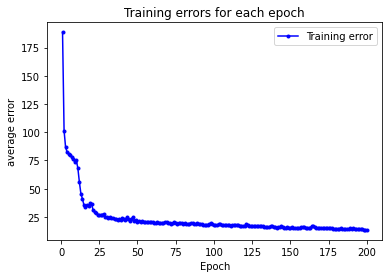

In [ ]:
epochs= 200
batch_size= 64
learning_rate= 0.0001
data_dir='data/KingsCollege/'

train(epochs, batch_size, learning_rate, save_freq, data_dir)

In [ ]:
def get_accuracy(pred_xyz, pred_wpqr, poses_gt):
    pose_xyz = poses_gt[0:3]
    pose_wpqr = poses_gt[3:]

    # Calculate position and rotation error
    q1 = pose_wpqr / np.linalg.norm(pose_wpqr)
    q2 = pred_wpqr / np.linalg.norm(pred_wpqr)
    d = abs(np.sum(np.multiply(q1, q2)))
    theta = 2 * np.arccos(d) * 180 / np.pi
    error_x = np.linalg.norm(pose_xyz - pred_xyz)

    return error_x, theta

def test(epoch, data_dir):
    # test dataset and test loader
    datasource = DataSource(data_dir, train=False)
    test_loader = DataLoader(dataset=datasource, batch_size=batch_size, shuffle=True)
    results = np.zeros((len(test_loader.dataset), 2))

    # load model
    posenet = PoseNet(load_weights=False).to(device,dtype=float)

    save_filename = 'epoch_{}.pth'.format(str(epoch).zfill(5))
    save_path = os.path.join('checkpointsC_b150', save_filename)
    posenet.load_state_dict(torch.load(save_path))
    print("Checkpoint {} loaded!".format(save_filename))


    with torch.no_grad():
        posenet.eval()
        for step, (images, poses) in enumerate(test_loader):
            b_images = Variable(images).to(device,dtype=float)
            poses[0] = np.array(poses[0])
            poses[1] = np.array(poses[1])
            poses[2] = np.array(poses[2])
            poses[3] = np.array(poses[3])
            poses[4] = np.array(poses[4])
            poses[5] = np.array(poses[5])
            poses[6] = np.array(poses[6])
            poses = np.transpose(poses)
            b_poses = Variable(torch.Tensor(poses)).to(device,dtype=float)

            p_xyz, p_wpqr = posenet(b_images)

            p_xyz_np = p_xyz.cpu().numpy()
            p_wpqr_np = p_wpqr.cpu().numpy()

            for i in range(b_poses.shape[0]):
                print("{}".format(step*batch_size+i))
                print("GT\t| xyz: {}\twpqr: {}".format(poses[i,:3], poses[i, 3:]))
                print("PRED\t| xyz: {}\twpqr: {}".format(p_xyz_np[i]*50, p_wpqr_np[i]))

                pos_error, ori_error = get_accuracy(p_xyz_np[i]*50, p_wpqr_np[i], poses[i])
                results[step*batch_size+i, :] = [pos_error, ori_error]
                print("ACC\t| pos: {} m \tori: {} degrees".format(pos_error, ori_error))

        median_result = np.median(results, axis=0)
        print("-----------------------------")
        print("Median position error: {} m \t Median orientation error: {} degrees".format(median_result[0], median_result[1]))
        print("Mean position error: {}".format(np.mean(results[:,0])))
        print("Mean orientation error: {}".format(np.mean(results[:,1])))



#Prediction at Epoch 198

In [ ]:
epochs=198
batch_size= 64
data_dir='data/KingsCollege/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

test(epochs, data_dir)

Mean image loaded!
PoseNet model created!
Checkpoint epoch_00198.pth loaded!
0
GT	| xyz: [ 23.178462 -26.182215   2.059261]	wpqr: [ 0.729576  0.655586  0.131515 -0.143631]
PRED	| xyz: [ 32.01653589 -25.58181508   1.7580386 ]	wpqr: [ 0.72200234  0.65367049  0.11589397 -0.12778196]
ACC	| pos: 8.863563903720257 m 	ori: 2.4102612592740864 degrees
1
GT	| xyz: [ 47.012622 -32.123869   2.034306]	wpqr: [ 0.689956  0.65499   0.184732 -0.246622]
PRED	| xyz: [ 50.80387078 -29.77854722   1.59375077]	wpqr: [ 0.67773795  0.62506493  0.22083534 -0.27345482]
ACC	| pos: 4.479753394328061 m 	ori: 6.2039391765681975 degrees
2
GT	| xyz: [ 40.835689 -29.964266   1.676046]	wpqr: [ 0.69394  0.63114  0.21614 -0.27091]
PRED	| xyz: [ 48.32870557 -29.23543328   1.60835469]	wpqr: [ 0.68526207  0.63088596  0.20798493 -0.25662155]
ACC	| pos: 7.528683588904836 m 	ori: 1.6659520502066663 degrees
3
GT	| xyz: [ 14.628859 -24.777264   1.88196 ]	wpqr: [ 0.762735  0.645918 -0.03175   0.004187]
PRED	| xyz: [ 10.89686053 -2

#Prediction at Epoch 53
This is the first time for this model to pass the performance threshold.

In [ ]:
epochs=53
data_dir='data/KingsCollege/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

test(epochs, data_dir)

Mean image loaded!
PoseNet model created!
Checkpoint epoch_00053.pth loaded!
0
GT	| xyz: [-10.880652 -19.515416   1.592769]	wpqr: [ 0.699763  0.614805 -0.249096  0.265139]
PRED	| xyz: [-11.40400002 -16.99261608   1.85617034]	wpqr: [ 0.72350349  0.58501892 -0.26458036  0.27307404]
ACC	| pos: 2.5899407019085707 m 	ori: 4.750683845665334 degrees
1
GT	| xyz: [ 47.012622 -32.123869   2.034306]	wpqr: [ 0.689956  0.65499   0.184732 -0.246622]
PRED	| xyz: [ 48.35404945 -29.12986229   1.6930241 ]	wpqr: [ 0.69619763  0.6243721   0.20513138 -0.26889443]
ACC	| pos: 3.2984810320353732 m 	ori: 4.953211893776246 degrees
2
GT	| xyz: [-29.269544 -13.728495   1.594069]	wpqr: [ 0.665765  0.545036 -0.315019  0.400569]
PRED	| xyz: [-24.05342948 -13.92214412   1.65515411]	wpqr: [ 0.64180577  0.55144871 -0.36142382  0.39842672]
ACC	| pos: 5.220065327913533 m 	ori: 6.019238172162014 degrees
3
GT	| xyz: [ 89.253569 -44.210593   2.259424]	wpqr: [ 0.643529  0.596224  0.272824 -0.394909]
PRED	| xyz: [ 58.82051468